# Step1: 检查路径及所有的库是否齐全。

In [1]:
# 检查文件夹路径是否正确
import os
os.chdir("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\TransNAR")
os.getcwd()

'D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\TransNAR'

In [2]:
# 检查所需的基本库是否齐全
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torch_geometric
from torch_geometric.nn import GINConv

from salsaclrs import SALSACLRSDataset, SALSACLRSDataLoader

# 导入自定义模块以确保它们可用
from models.nar import NARGNN
from models.transnar import TransNARModel
from utils.tokenizer import SimpleTokenizer

print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("pyg version:", torch_geometric.__version__)
print("salsaclrs imported OK")


torch version: 2.9.0+cu128
cuda available: True
pyg version: 2.7.0
salsaclrs imported OK


# Step2: 检查图数据是否存在并查看格式。

In [ ]:
from salsaclrs import SALSACLRSDataset, SALSACLRSDataLoader

# 创建图数据集实例
graph_ds = SALSACLRSDataset(
    root="data/raw",
    split="train", # 训练集
    algorithm="bfs", # BFS 广度优先搜索
    num_samples=10000, # 样本数量
    graph_generator="er", # ER 随机图
    graph_generator_kwargs={"n": 16, "p": 0.1}, # 图生成器参数 n 节点数, p 边概率
    hints=True, # 是否包含提示信息
)

# 输出图数据集的信息
print("num graphs:", len(graph_ds)) # should be 10000 图的数量
g0 = graph_ds[0] # 获取第一个图
print("g0:", g0) # 查看第一个图的详细信息
print("  edge_index shape:", g0.edge_index.shape) # 图结构 BFS输入
print("  pos shape:", g0.pos.shape) # 节点ID
print("  s shape:", g0.s.shape)     # BFS源点
print("  reach_h shape:", g0.reach_h.shape) # 可达高度形状

num graphs: 10000
g0: CLRSData(edge_index=[2, 48], pos=[16], length=8, s=[16], pi=[48], reach_h=[16, 8], pi_h=[48, 8], hints=[2], inputs=[2], outputs=[1])
  edge_index shape: torch.Size([2, 48])
  pos shape: torch.Size([16])
  s shape: torch.Size([16])
  reach_h shape: torch.Size([16, 8])


In [10]:
# 创建数据加载器并获取一个批次 
# 确保CLRS图数据能够正确地进行批处理 batch
graph_loader = SALSACLRSDataLoader(graph_ds,  # 刚刚创建的图数据集
                                   batch_size=32,  # 批次大小
                                   shuffle=True # 是否打乱数据
                                   ) # 创建数据加载器
batch0 = next(iter(graph_loader)) # 获取第一个批次
print("batch0:", batch0) # 查看批次的详细信息
print("  batch edge_index:", batch0.edge_index.shape)
print("  batch pos:", batch0.pos.shape)
print("  batch reach_h:", batch0.reach_h.shape)
print("  batch batch vector:", batch0.batch.shape) # 批次向量形状

batch0: CLRSDataBatch(edge_index=[2, 1680], pos=[512], length=[32], s=[512], pi=[1680], reach_h=[512, 11], pi_h=[1680, 11], hints=[2], inputs=[2], outputs=[1], batch=[512], ptr=[33])
  batch edge_index: torch.Size([2, 1680])
  batch pos: torch.Size([512])
  batch reach_h: torch.Size([512, 11])
  batch batch vector: torch.Size([512])


# Step3：图可视化

In [15]:
# 准备
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from salsaclrs import SALSACLRSDataset

# 加载你之前的 BFS 图数据集
graph_ds = SALSACLRSDataLoader = SALSACLRSDataset(
    root="data/raw",
    split="train",
    algorithm="bfs",
    num_samples=10000,
    graph_generator="er",
    graph_generator_kwargs={"n": 16, "p": 0.1},
    hints=True,
)

g0 = graph_ds[0]     # 取第一个图
G = to_networkx(g0, to_undirected=True)

print("g0:", g0)


g0: CLRSData(edge_index=[2, 48], pos=[16], length=8, s=[16], pi=[48], reach_h=[16, 8], pi_h=[48, 8], hints=[2], inputs=[2], outputs=[1])


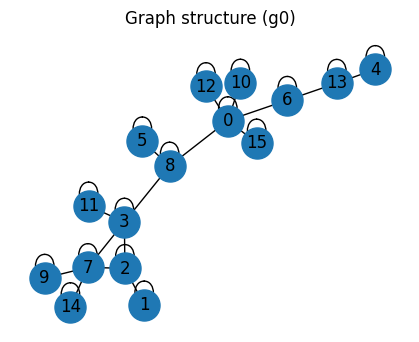

In [21]:
# 绘制第一个图
plt.figure(figsize=(4, 3))
pos = nx.spring_layout(G, seed=42)
nx.draw(G,    
        pos,  
        with_labels=True, 
        node_size=500)
plt.title("Graph structure (g0)")
plt.show()

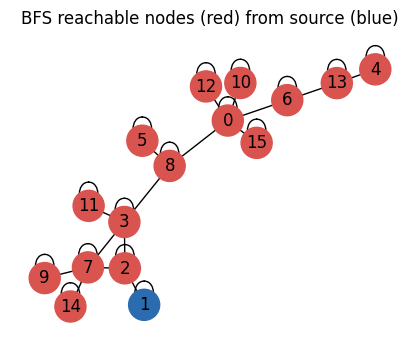

In [38]:
# 取 BFS 源点
s = g0.s
if s.ndim > 1:
    s = s[:, 0]
src = int(torch.argmax(s).item())

# 最终可达性
reach = g0.reach_h[:, -1]    # [num_nodes]
reachable_nodes = set(i for i, v in enumerate(reach.tolist()) if v > 0.5)

# 配置颜色
node_colors = []
for node in G.nodes():
    if node == src:
        node_colors.append("#2b6cb0")
    elif node in reachable_nodes:
        node_colors.append("#d9534f")
    else:
        node_colors.append("lightgray")

plt.figure(figsize=(4, 3))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors)
plt.title("BFS reachable nodes (red) from source (blue)")
plt.show()

BFS layers:
  Level 0: [1]
  Level 1: [2]
  Level 2: [3, 7]
  Level 3: [8, 9, 11, 14]
  Level 4: [0, 5]
  Level 5: [6, 10, 12, 15]
  Level 6: [13]
  Level 7: [4]


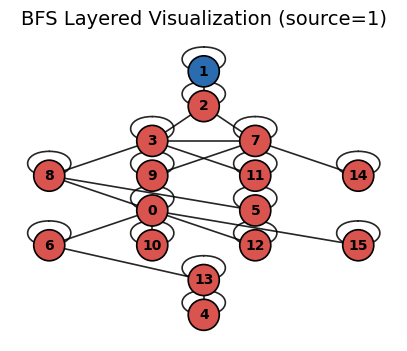

In [30]:
import matplotlib.pyplot as plt
import networkx as nx

# ---- BFS 层级计算 ----
levels = dict(nx.single_source_shortest_path_length(G, src))

# 按 level 分组节点
level_nodes = {}
for node, d in levels.items():
    level_nodes.setdefault(d, []).append(node)

print("BFS layers:")
for lvl in sorted(level_nodes.keys()):
    print(f"  Level {lvl}: {sorted(level_nodes[lvl])}")


# ---- 布局：按层排布 ----
pos = {}
x_spacing = 2.0
y_spacing = 1.6

for lvl, nodes in sorted(level_nodes.items()):
    k = len(nodes)
    x0 = -(k - 1) / 2.0 * x_spacing
    for i, node in enumerate(sorted(nodes)):
        pos[node] = (x0 + i * x_spacing, -lvl * y_spacing)


# ---- 颜色方案 ----
node_colors = []
for node in G.nodes():
    if node == src:
        node_colors.append("#2b6cb0")  # 蓝色（源点）
    elif node in reachable_nodes:
        node_colors.append("#d9534f")  # 红色（可达）
    else:
        node_colors.append("lightgray")  # 不可达


# ---- 绘制（不画 level） ----
plt.figure(figsize=(5, 4))

# 节点 + 边 + 标签
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=500, # 节点大小
    edgecolors="black",
    linewidths=1.2
)
nx.draw_networkx_labels(
    G,
    pos,
    font_size=10,
    font_weight="bold"
)
nx.draw_networkx_edges(
    G,
    pos,
    width=1.2,
    alpha=0.85
)

plt.title(f"BFS Layered Visualization (source={src})", fontsize=14)
plt.axis("off")
plt.show()


In [31]:
import numpy as np

# 用 spring_layout 或你之前的 BFS 分层布局都可以，这里用 spring_layout
pos = nx.spring_layout(G, seed=42)

# reach_h: [num_nodes, T]，每一列一个时间步
reach_h = g0.reach_h    # torch tensor
reach_np = reach_h.numpy()
num_nodes, T = reach_np.shape
print("reach_h shape:", reach_np.shape)  # (N, T)


reach_h shape: (16, 8)


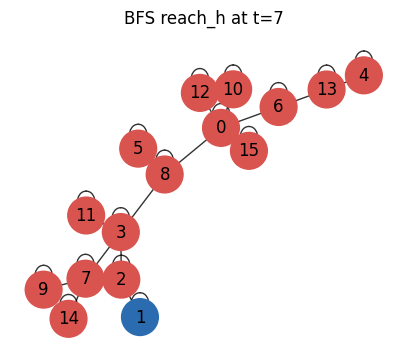

In [47]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from IPython.display import HTML

# ----------- 动画核心部分（你已有的）----------------

def get_colors_at_t(t):
    colors = []
    for i, node in enumerate(nodes):
        if node == src:
            colors.append("#2b6cb0")  # 蓝
        else:
            v = reach_np[i, t]
            if v > 0.5:
                colors.append("#d9534f")  # 红
            else:
                colors.append("lightgray")  # 灰
    return colors

fig, ax = plt.subplots(figsize=(5,4))

edges = nx.draw_networkx_edges(G, pos, ax=ax, width=1.0, alpha=0.8)
nodes_artist = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_color=get_colors_at_t(0),
    node_size=700,
    edgecolors="black",
    linewidths=1.0
)
nx.draw_networkx_labels(G, pos, ax=ax)

title = ax.text(0.5, 1.03, "", transform=ax.transAxes,
                ha="center", va="bottom", fontsize=12)

ax.axis("off")

def init():
    nodes_artist.set_color(get_colors_at_t(0))
    title.set_text("BFS reach_h at t=0")
    return nodes_artist, title

def update(frame):
    nodes_artist.set_color(get_colors_at_t(frame))
    title.set_text(f"BFS reach_h at t={frame}")
    return nodes_artist, title

anim = FuncAnimation(
    fig,
    update,
    frames=T,
    init_func=init,
    interval=800,
    blit=True
)

# ----------- 保存为 GIF ----------------

# 注意：writer="pillow" 可以在 Windows 无痛运行
anim.save("Figure/bfs_animation.gif", writer="pillow", fps=2)

plt.show()
plt.close(fig)



# Step4：检查文本数据

In [ ]:
# 文本文件是否存在
import os
text_path = "data/text/bfs_text_train.jsonl"
print("文件是否存在：", os.path.exists(text_path))
print("文件大小（字节）：", os.path.getsize(text_path))

文件是否存在： True
文件大小（字节）： 3002574


In [ ]:
# 检查文本文件内容 jsonl 格式是否正确
import json
with open("data/text/bfs_text_train.jsonl", "r", encoding="utf-8") as f:
    for i in range(5):   # 查看前 5 行
        line = f.readline()
        print(json.loads(line))


{'text_in': 'bfs: n=16, edges=[(0, 0), (0, 6), (0, 8), (0, 10), (0, 12), (0, 15), (1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (2, 7), (3, 2), (3, 3), (3, 7), (3, 8), (3, 11), (4, 4), (4, 13), (5, 5), (5, 8), (6, 0), (6, 6), (6, 13), (7, 2), (7, 3), (7, 7), (7, 9), (7, 14), (8, 0), (8, 3), (8, 5), (8, 8), (9, 7), (9, 9), (10, 0), (10, 10), (11, 3), (11, 11), (12, 0), (12, 12), (13, 4), (13, 6), (13, 13), (14, 7), (14, 14), (15, 0), (15, 15)], start=1', 'text_out': 'reachable: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]', 'graph_idx': 0}
{'text_in': 'bfs: n=16, edges=[(0, 0), (0, 5), (0, 8), (0, 11), (1, 1), (1, 4), (1, 8), (1, 10), (2, 2), (2, 4), (2, 6), (3, 3), (3, 6), (3, 8), (3, 11), (3, 13), (4, 1), (4, 2), (4, 4), (4, 14), (5, 0), (5, 5), (6, 2), (6, 3), (6, 6), (7, 7), (7, 9), (7, 15), (8, 0), (8, 1), (8, 3), (8, 8), (8, 9), (9, 7), (9, 8), (9, 9), (10, 1), (10, 10), (10, 12), (11, 0), (11, 3), (11, 11), (12, 10), (12, 12), (13, 3), (13, 13), (13, 14), (14, 4), (14, 13), (14, 14

In [ ]:
# 读一条文本 → 对照原图结构
# 读取文本
import json
with open("data/text/bfs_text_train.jsonl", "r", encoding="utf-8") as f:
    sample = json.loads(f.readline())
sample


{'text_in': 'bfs: n=16, edges=[(0, 0), (0, 6), (0, 8), (0, 10), (0, 12), (0, 15), (1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (2, 7), (3, 2), (3, 3), (3, 7), (3, 8), (3, 11), (4, 4), (4, 13), (5, 5), (5, 8), (6, 0), (6, 6), (6, 13), (7, 2), (7, 3), (7, 7), (7, 9), (7, 14), (8, 0), (8, 3), (8, 5), (8, 8), (9, 7), (9, 9), (10, 0), (10, 10), (11, 3), (11, 11), (12, 0), (12, 12), (13, 4), (13, 6), (13, 13), (14, 7), (14, 14), (15, 0), (15, 15)], start=1',
 'text_out': 'reachable: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]',
 'graph_idx': 0}

In [ ]:
# 对照图结构 保持一致
g = graph_ds[sample["graph_idx"]]
print(g.edge_index)
print(g.reach_h[:, -1])
print(sample["text_in"])
print(sample["text_out"])

tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,
          4,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9, 10,
         10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15],
        [ 0,  6,  8, 10, 12, 15,  1,  2,  1,  2,  3,  7,  2,  3,  7,  8, 11,  4,
         13,  5,  8,  0,  6, 13,  2,  3,  7,  9, 14,  0,  3,  5,  8,  7,  9,  0,
         10,  3, 11,  0, 12,  4,  6, 13,  7, 14,  0, 15]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
bfs: n=16, edges=[(0, 0), (0, 6), (0, 8), (0, 10), (0, 12), (0, 15), (1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (2, 7), (3, 2), (3, 3), (3, 7), (3, 8), (3, 11), (4, 4), (4, 13), (5, 5), (5, 8), (6, 0), (6, 6), (6, 13), (7, 2), (7, 3), (7, 7), (7, 9), (7, 14), (8, 0), (8, 3), (8, 5), (8, 8), (9, 7), (9, 9), (10, 0), (10, 10), (11, 3), (11, 11), (12, 0), (12, 12), (13, 4), (13, 6), (13, 13), (14, 7), (14, 14), (15, 0), (15, 15)], start=1
reachable: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

# Step5：检查Tokenizer

In [ ]:
# build vocab 检查 tokenizer
import json
from utils.tokenizer import SimpleTokenizer

text_path = "data/text/bfs_text_train.jsonl"

# 收集所有 text_in 和 text_out
texts = []
with open(text_path, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        texts.append(obj["text_in"])
        texts.append(obj["text_out"])

print("样本条数（包含 in/out）：", len(texts))

# 用你的 tokenizer 建 vocab
tok = SimpleTokenizer(min_freq=1)
tok.build_vocab(texts)

print("Vocab size:", tok.vocab_size)
print("前 30 个 token:", tok.id2token[:30])
print("PAD token id:", tok.token2id[tok.pad_token])  # 填充序列
print("UNK token id:", tok.token2id[tok.unk_token])  # 未知词
print("BOS token id:", tok.token2id[tok.bos_token])  # 句子开始
print("EOS token id:", tok.token2id[tok.eos_token])  # 句子结束

样本条数（包含 in/out）： 10000
Vocab size: 33
前 30 个 token: ['<pad>', '<unk>', '<bos>', '<eos>', 'bfs', ':', 'n', '=', '16', ',', 'edges', '[', '(', '0', ')', '6', '8', '10', '12', '15', '1', '2', '3', '7', '11', '4', '13', '5', '9', '14']
PAD token id: 0
UNK token id: 1
BOS token id: 2
EOS token id: 3


In [68]:
# 检查 tokenizer 的 tokenize, encode, decode 功能
import random, json

# 随机挑一条样本
with open(text_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

sample = json.loads(random.choice(lines))
print("原始 text_in :", sample["text_in"])
print("原始 text_out:", sample["text_out"])

# 看 tokenizer.tokenize 的效果
print("\n[Tokenize text_in]")
print(tok.tokenize(sample["text_in"]))

print("\n[Tokenize text_out]")
print(tok.tokenize(sample["text_out"]))

# encode + decode
ids_in = tok.encode(sample["text_in"], add_special_tokens=True, max_len=512)
ids_out = tok.encode(sample["text_out"], add_special_tokens=True, max_len=512)

print("\n[Encoded ids_in]:", ids_in)
print("[Decoded text_in ]:", tok.decode(ids_in))

print("\n[Encoded ids_out]:", ids_out)
print("[Decoded text_out ]:", tok.decode(ids_out))


原始 text_in : bfs: n=16, edges=[(0, 0), (0, 3), (0, 9), (0, 13), (1, 1), (1, 7), (1, 8), (1, 11), (2, 2), (2, 8), (2, 14), (3, 0), (3, 3), (3, 9), (4, 4), (4, 5), (4, 10), (4, 15), (5, 4), (5, 5), (5, 12), (6, 6), (6, 8), (7, 1), (7, 7), (7, 8), (8, 1), (8, 2), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 3), (9, 8), (9, 9), (10, 4), (10, 10), (10, 13), (11, 1), (11, 11), (12, 5), (12, 12), (13, 0), (13, 10), (13, 13), (14, 2), (14, 14), (15, 4), (15, 15)], start=7
原始 text_out: reachable: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

[Tokenize text_in]
['bfs', ':', 'n', '=', '16', ',', 'edges', '=', '[', '(', '0', ',', '0', ')', ',', '(', '0', ',', '3', ')', ',', '(', '0', ',', '9', ')', ',', '(', '0', ',', '13', ')', ',', '(', '1', ',', '1', ')', ',', '(', '1', ',', '7', ')', ',', '(', '1', ',', '8', ')', ',', '(', '1', ',', '11', ')', ',', '(', '2', ',', '2', ')', ',', '(', '2', ',', '8', ')', ',', '(', '2', ',', '14', ')', ',', '(', '3', ',', '0', ')', ',', '(', '3', ',', '3', ')'

In [69]:
# 检查序列长度分布
lengths = []
with open(text_path, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        full_text = obj["text_in"] + " " + obj["text_out"]
        ids = tok.encode(full_text, add_special_tokens=True)  # 不截断
        lengths.append(len(ids))

print("样本数:", len(lengths))
print("最长长度:", max(lengths))
print("平均长度:", sum(lengths) / len(lengths))
print("前 20 个长度:", lengths[:20])

样本数: 5000
最长长度: 482
平均长度: 367.7408
前 20 个长度: [338, 362, 362, 374, 338, 410, 398, 350, 338, 326, 326, 398, 350, 362, 350, 350, 398, 350, 326, 374]


In [74]:
# 检查 Dataset + DataLoader 的 batch 功能
from train_transnar import BFSTextSeqDataset, collate_seq_batch
from torch.utils.data import DataLoader
pad_id = tok.token2id[tok.pad_token]
text_ds = BFSTextSeqDataset(text_path, tok, max_len=512)
print("文本样本数量:", len(text_ds))

loader = DataLoader(
    text_ds,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda b: collate_seq_batch(b, pad_id)
)

batch = next(iter(loader))
print("input_ids shape:", batch["input_ids"].shape)
print("target_ids shape:", batch["target_ids"].shape)
print("graph_idx:", batch["graph_idx"])
print("第一条 input_ids:", batch["input_ids"][0].tolist())
print("第一条 decode:", tok.decode(batch["input_ids"][0].tolist()))

文本样本数量: 5000
input_ids shape: torch.Size([4, 386])
target_ids shape: torch.Size([4, 386])
graph_idx: tensor([4799, 4262, 2277,  151])
第一条 input_ids: [2, 4, 5, 6, 7, 8, 9, 10, 7, 11, 12, 13, 9, 13, 14, 9, 12, 13, 9, 26, 14, 9, 12, 20, 9, 20, 14, 9, 12, 20, 9, 19, 14, 9, 12, 21, 9, 21, 14, 9, 12, 21, 9, 25, 14, 9, 12, 21, 9, 27, 14, 9, 12, 21, 9, 16, 14, 9, 12, 21, 9, 17, 14, 9, 12, 21, 9, 19, 14, 9, 12, 22, 9, 22, 14, 9, 12, 22, 9, 23, 14, 9, 12, 22, 9, 16, 14, 9, 12, 22, 9, 17, 14, 9, 12, 25, 9, 21, 14, 9, 12, 25, 9, 25, 14, 9, 12, 25, 9, 24, 14, 9, 12, 25, 9, 29, 14, 9, 12, 27, 9, 21, 14, 9, 12, 27, 9, 27, 14, 9, 12, 27, 9, 18, 14, 9, 12, 27, 9, 19, 14, 9, 12, 15, 9, 15, 14, 9, 12, 15, 9, 28, 14, 9, 12, 23, 9, 22, 14, 9, 12, 23, 9, 23, 14, 9, 12, 23, 9, 16, 14, 9, 12, 23, 9, 24, 14, 9, 12, 16, 9, 21, 14, 9, 12, 16, 9, 22, 14, 9, 12, 16, 9, 23, 14, 9, 12, 16, 9, 16, 14, 9, 12, 16, 9, 17, 14, 9, 12, 28, 9, 15, 14, 9, 12, 28, 9, 28, 14, 9, 12, 28, 9, 17, 14, 9, 12, 28, 9, 26, 14, 9, 12, 